Name: Benjamin Fraeyman

In this exercise we will perform anomaly detection on time series data without having example anomalies or making fundamental assumptions about the data. This means we can only assume anomalies are rare events that will have a distinct pattern.

We will use a dataset counting the number of **taxi rides in New York city from 2014-2015**. As we all know from Hollywood, a lot of exciting things happen to New York and its taxi drivers.

In this exercise we will use the **Matrix Profile** to find the anomalies in the taxi driver data.

---

In [1]:
# ![My Title](NewYorkTaxis.jpg)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import fftconvolve
import itertools

# immediate plot
%matplotlib inline

# Bigger default pictures
mpl.rcParams['figure.figsize'] = (15,5)

import datetime
from datetime import timedelta
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [2]:
data = pd.read_csv("nyc_taxi.csv", index_col='timestamp', parse_dates=True)

Make a plot of the entire dataset.

,value
timestamp,
2014-07-01,10844


,value
timestamp,
2015-01-31 23:30:00,26288


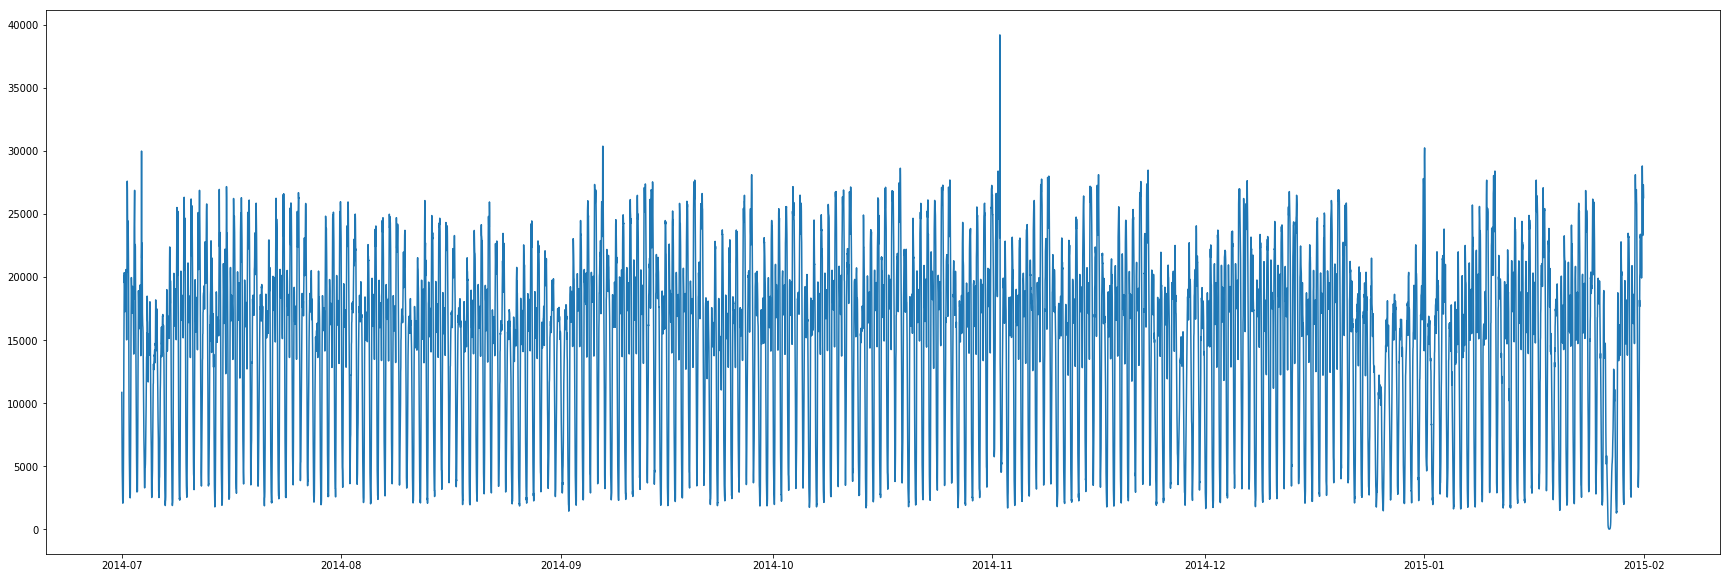

In [3]:
display(data.head(1))
display(data.tail(1))
fig = plt.figure(figsize=(30,10))
plt.plot(data)
plt.show()

Make a plot that displays the seasonality of the data.
To do this, set the x-axis to cover a period of one week (starting at monday),
plot a single graph per week in the data, so that every week is overlayed.
This is sometimes called a "seasonal plot", an example of such a plot can be found [here](https://i.stack.imgur.com/EOM9k.png).
Add some kind of visual indication for midnight, so you can easily observe individual days in the week pattern.

,value,time,week
timestamp,,,
2014-07-01 00:00:00,10844,2014-07-01 00:00:00,1
2014-07-01 00:30:00,8127,2014-07-01 00:30:00,1
2014-07-01 01:00:00,6210,2014-07-01 01:00:00,1
2014-07-01 01:30:00,4656,2014-07-01 01:30:00,1
2014-07-01 02:00:00,3820,2014-07-01 02:00:00,1


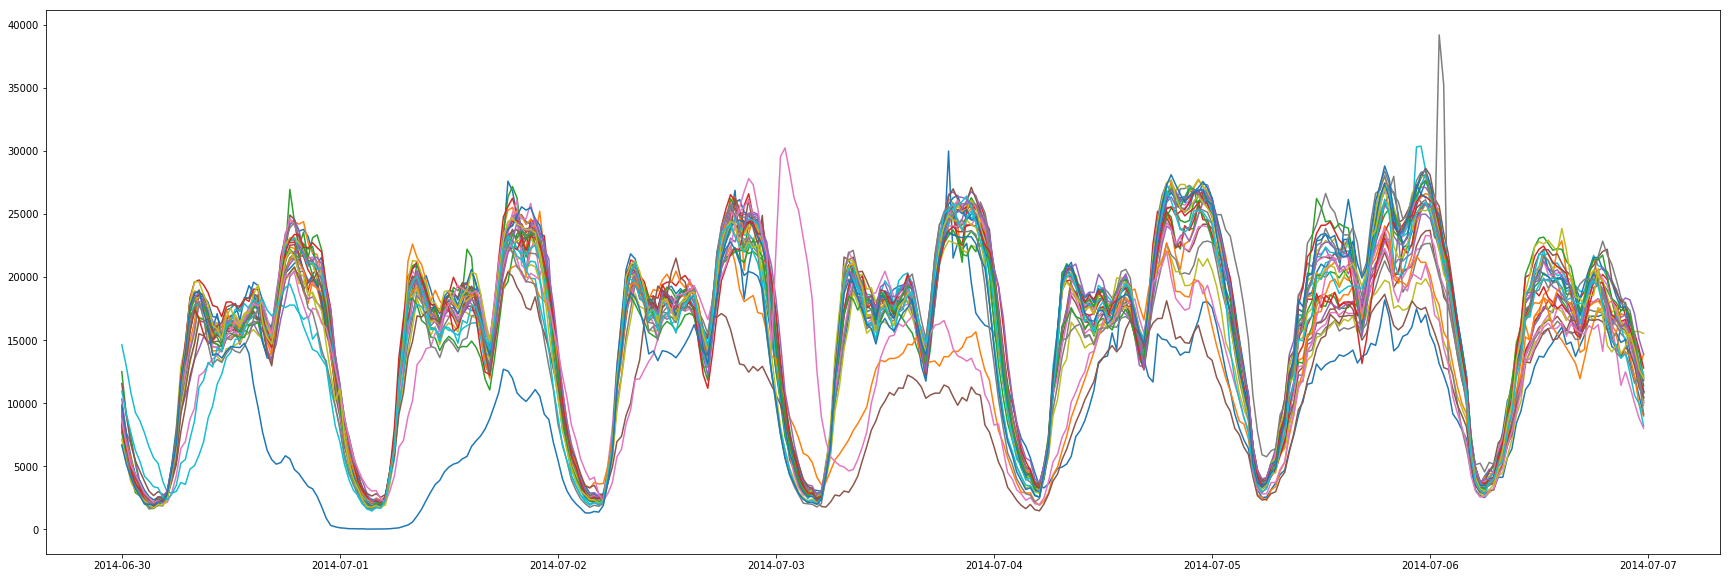

In [4]:
# display(data.index.values)
data['time'] = data.index.values
data['week'] = data['time'].dt.dayofweek
display(data.head(5))
weeks = [g for n, g in data.groupby(pd.TimeGrouper('W'))]

i = 0
fig = plt.figure(figsize=(30,10))
for week in weeks:   
    plt.plot( week['time'] -timedelta(days=i*7 ),week['value'] )
    i +=1
plt.show()

Give some insights on the data you see. Don't overthink. (Give at least 4.)
>We see a clear weekly periodic pattern: almost all weeks show similar behaviour.<br/>
Timeframes are distinguishable (day, night, noon)<br/>
Daily repeating patterns<br/>
Some outliers

# Matrix Profile

The Matrix Profile is a new series derived from a given time series. The value at index $i$ of the Matrix Profile for series $S$
contains the lowest distance of the subsequence starting at $S[i]$ to any other subsequence in $S$
(excluding subsequences near $S[i]$ itself, the so called *trivial matches*).
Low values in the Matrix profile indicate that a subsequence is similar to another subsequence.
High values indicate a subsequence has no similar match.

Series discords (= the most dissimilar subsequences in a series) can often be interpreted as anomalies.

The Matrix Profile algorithms works by sliding a window of size $m$ over a data series. For each subsequence ($X$) in the window, it finds the distance to its closest match ($Y$). As a distance metric it uses the z-normalised Euclidean distance. 

For efficiency reasons, a less straight-forward formula is used to calculate these distances:

\begin{equation}
d(\hat{X}, \hat{Y}) = \sqrt{2m(1 - \frac{\sum_{i=1}^m x_i y_i - m \mu_x \mu_y}{m \sigma_x \sigma_y})}
\end{equation}

where:

- $d(X, Y)$: the Euclidean distance between $X$ and $Y$
- $\hat{X}$: the z-normalized window $X$
- $m$: the size of the time window (length of $X$ and $Y$)
- $\mu_x$: the mean of the window $X$
- $\sigma_x$: the standard deviation of the window $Y$

Note that in this formula $x_i$ and $y_i$ are elements from the original sequence ($X$ and $Y$) and not of the normalised sequence ($\hat{X}$ and $\hat{Y}$).

As a reminder, z-normalisation is done as follows:
\begin{equation}
\hat{X} = \frac{X - \mu_X}{\sigma_X}
\end{equation}

---

Being the critical thinkers that we are, let's verify that this formula actually works out.

Implement a function for z-normalisation, euclidean distance and the formula used by the Matrix Profile (as listed above).
You can assume the standard deviation will never be 0.

In [5]:
def znorm(data):
    result =[]
    avg =data.mean()
    std =data.std()
    for i in data:
        result.append((i - avg) /std ) 
    return result
#     pass

def eucl(x, y):
    return  distance.euclidean(x, y)
#     pass

def znorm_eucl(x, y):
    # Note that this method takes the non-normalised subsequences as input!
    a = znorm(x)
    b = znorm(y)
    return eucl(a,b)
#     pass

Now test the correctness of the formula on some randomly chosen time windows of data.

In [6]:
subseq1 = weeks[1]['value']
subseq2 = weeks[2]['value']
print(eucl(znorm(subseq1), znorm(subseq2)), znorm_eucl(subseq1, subseq2))

3.1723903724360243 3.1723903724360243


The reason this other formula is used, is because the mean and standard deviation can be easily precomputed, and the dot products can easily be updated during the calculation of the Matrix Profile.

## Sliding mean and standard deviation

In [7]:
def sliding_avg_std(array, m):
    """
    This method calculates all means and standard deviations of a window (of size m) sliding over an 1-D array.
    """
    if array.ndim != 1:
        raise RuntimeError("Series should be 1D")
    
    val_diff = array.copy()  # x0  x1  x2  x3 ...
    val_diff[m:] -= array[:-m]  # x0  x1  x2-x0  x3-x1 ... (m = 2)
    sliding_avg = np.cumsum(val_diff / m)[m-1:]  # x0+x1  x0+x1+x2-x0  x0+x1+(x2-x0)+(x3-x1) ...

    val_sq_diff = np.square(array)
    val_sq_diff[m:] -= val_sq_diff[:-m]
    series_sum_sq = np.cumsum(val_sq_diff / m)[m-1:]

    sliding_var = series_sum_sq - np.square(sliding_avg)  # std^2 = E[X²] - E[X]²
    sliding_var[sliding_var < 1e-10] = 0  # Due to rounding errors, zero values can have very small non-zero values

    return sliding_avg, np.sqrt(sliding_var)

Oh no, more weird ways to calculate simple things!
What would be the advantage of doing this? Let's find out.

Implement the simple (brute-force) way to calculate the sliding mean/std over an array of values.

In [8]:
def simple_avg_std(array, m):
    b = np.empty(array.size-m+1)
    for i in range(b.size):
        b[i] = np.std(array[i:i+m])
    return b

Now compare their timings using the `%timeit` command.

In [9]:
# %timeit sliding_avg_std(data.values.ravel(), 100)
%timeit sliding_avg_std(data['value'].values.ravel(), 100)
%timeit simple_avg_std(data['value'].values.ravel(), 100)

188 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
237 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
print(sliding_avg_std(data['value'].values.ravel(), 100))
print(simple_avg_std(data['value'].values.ravel(), 100))

(array([15183.29, 15133.11, 15095.67, ..., 17744.49, 17778.32, 17809.32]), array([7115.93198857, 7163.88612541, 7210.03852563, ..., 7537.25667534,
       7569.22728537, 7597.61415561]))
[7115.93198857 7163.88612541 7210.03852563 ... 7537.25667534 7569.22728537
 7597.61415561]


What would you expect to happen if you increase ($*$ 2, $*$ 10...) the array size or the window size?
Test it out, and explain the results. (Ensure all your relevant timings are visible when handing in.)

In [11]:
window = 2*100
%timeit sliding_avg_std(data['value'].values.ravel(), window)
%timeit simple_avg_std(data['value'].values.ravel(), window)

189 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
233 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
window = 10*100
%timeit sliding_avg_std(data['value'].values.ravel(), window)
%timeit simple_avg_std(data['value'].values.ravel(), window)

184 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
228 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
window = 100*100
%timeit sliding_avg_std(data['value'].values.ravel(), window)
%timeit simple_avg_std(data['value'].values.ravel(), window)

145 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
16.6 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
size = 2
data2 = []
for i in range(0, size):
    data2.append(data['value'].values.ravel())
%timeit sliding_avg_std(np.asarray(data2).ravel(), 100)
%timeit simple_avg_std(np.asarray(data2).ravel(), 100)

360 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
455 ms ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
size = 10
data2 = []
for i in range(0, size):
    data2.append(data['value'].values.ravel())
%timeit sliding_avg_std(np.asarray(data2).ravel(), 100)
%timeit simple_avg_std(np.asarray(data2).ravel(), 100)

5.3 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.18 s ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
size = 100
data2 = []
for i in range(0, size):
    data2.append(data['value'].values.ravel())
%timeit sliding_avg_std(np.asarray(data2).ravel(), 100)
%timeit simple_avg_std(np.asarray(data2).ravel(), 100)

76.9 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.1 s ± 712 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see from the timings that:
> If window increases then time decreases<br/>
If size increases then time increases

This can be explained by:
> If window increases then the iteration reaches the end faster, thus less calculations<br/>
If size increases then more calculations are needed since there are more elements.

There is one downside to this approach however. Numerical errors can accumulate over time and cause minor differences. This will occur more in datasets with very high jumps in between data points. In this dataset, the error is negligable. (Feel free to verify this.)

## The good stuff

In [17]:
def matrix_profile(array, m):
    """
    This method calculates the Matrix Profile over the given 1D array using a window size of m.
    """
    if array.ndim != 1:
        raise RuntimeError("Series should be 1D")
    
    series = np.array(array, dtype=np.float, copy=True)
    mu, std = sliding_avg_std(series, m)
    
    num_windows = len(array) - m + 1
    mp = np.full(num_windows, np.nan, dtype=np.float)
    
    first_row = None
    dot_prod = None
    for column in range(num_windows):
        series_subseq = series[column: column + m]
        
        if dot_prod is None:
            # Efficient dot product calculation
            dot_prod = fftconvolve(series, series_subseq[::-1], 'valid')
            # Store the very first column, use its values as the first row.
            first_row = dot_prod.copy()
        else:
            dot_prod[1:] = (dot_prod[:-1]
                            - series[column - 1] * series[:len(series) - m]
                            + series[column + m - 1] * series[m:])
            dot_prod[0] = first_row[column]
            
        dist_sq = 2 * (m - (dot_prod - m * mu * mu[column]) / (std * std[column]))
        
        # Ignore trivial matches (those nearby to the subsequence we're using)
        dist_sq[max(0, column - m//2): min(len(series), column + m//2 + 1)] = np.inf
        
        mp[column] = np.min(np.sqrt(dist_sq))
    
    return mp

Calculate and visualize the Matrix Profile on the Taxi dataset, use a time window of 1 day.

In [18]:
display(matrix_profile(data['value'], 48))

array([0.77870087, 0.77881232, 0.78245679, ..., 0.75218551, 0.74705577,
       0.73072576])

Find the 3 highest values in the Matrix Profile.

In [19]:
temp = matrix_profile(data['value'], 48)
temp = temp.tolist()
largest_integer = max(temp)
temp.remove(largest_integer)
second_largest_integer = max(temp)
temp.remove(second_largest_integer)
third_largest_integer = max(temp)
print(largest_integer, " - ", second_largest_integer, " - ", third_largest_integer)

4.550439501966098  -  4.536759472526065  -  4.449804831463317


Each of these values corresponds to an anomalous subsequence of a period of one day.

Plot the entire time series, highlighting these 3 windows. When plotting, you should see something odd.

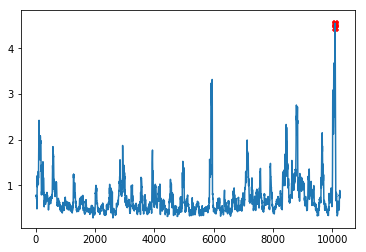

In [20]:
temp = matrix_profile(data['value'], 48)
temp = temp.tolist()
maxesx= [temp.index(largest_integer), temp.index(second_largest_integer), temp.index(third_largest_integer)]
maxesy = [largest_integer, second_largest_integer, third_largest_integer]
plt.plot(matrix_profile(data['value'], 48))
plt.scatter(maxesx, maxesy, marker= "X", c="red")
plt.show()

The 3 highest values all correspond to a single anomalous day.
It Looks like we need a smarter way to find individual anomalies.

Implement a way to find the X highest values, starting from the highest value,
where each new value should be at least 48 indices (one day) away from any previous value.

In [21]:
def findXmaxes(matrix_profile, numMaxes):
    matrix_profile = matrix_profile.tolist()
    ranks = sorted( [(x,i) for (i,x) in enumerate(matrix_profile)], reverse=True )
    values = []
    posns = []
    boolAppend = True
    for x,i in ranks:
        if x not in values:
            for zzz in posns:
                if ((zzz - 48) < i) & (i < (zzz + 48)):
                    boolAppend = False
            if boolAppend == True:
                values.append( x )
                posns.append( i )
            boolAppend = True
            if len(values) == numMaxes:
                break
    
    times = []
    for i in posns:
        times.append(data.iloc[[i]].index[0])
    print(times)
    
    vals = []
    for i in values:
        vals.append(data.iloc[[i]]["value"].values[0])
    
    return values, posns, times, vals

Use this method to find the timestamps of the top 7 anomalies.
Print these dates and highlight them in a plot.

[Timestamp('2015-01-27 09:00:00'), Timestamp('2014-11-02 00:30:00'), Timestamp('2015-01-25 20:30:00'), Timestamp('2014-12-31 05:30:00'), Timestamp('2014-07-03 07:00:00'), Timestamp('2014-12-24 00:30:00'), Timestamp('2015-01-18 09:00:00')]


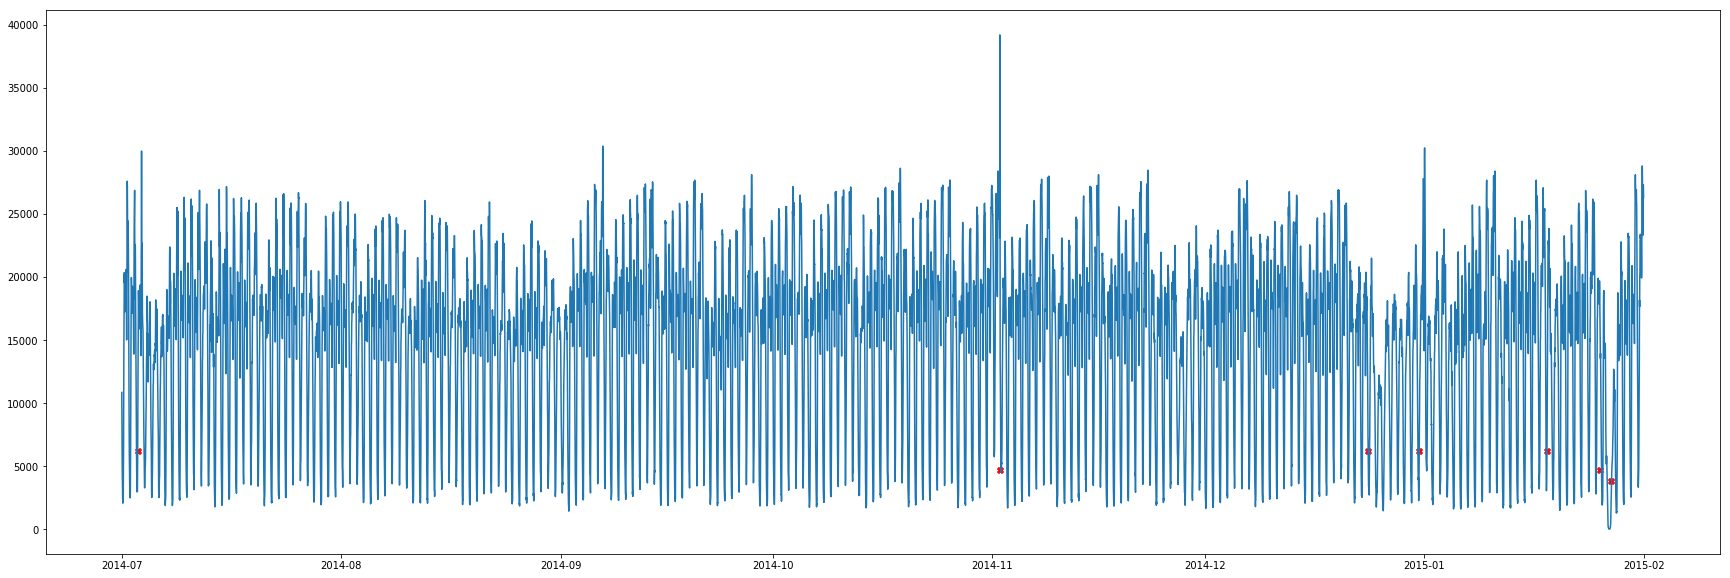

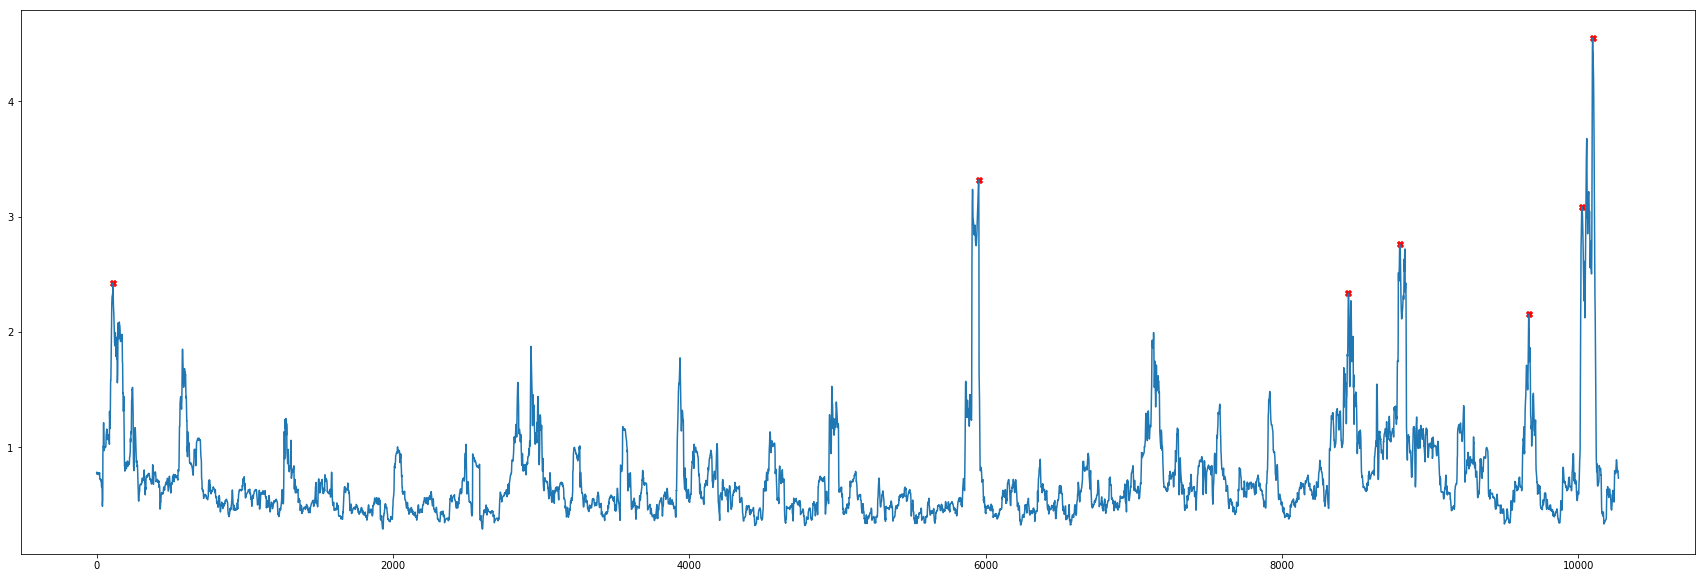

In [28]:
maxes, indexes, times, vals = findXmaxes(matrix_profile(data['value'], 48), 7)

# data.ix[10098]
# data.iloc[[10098]]
# data.iloc[[10098]]["value"].values[0]
# data.iloc[[10098]].index[0]

fig = plt.figure(figsize=(30,10))
plt.plot(data['value'])
plt.scatter(times, vals, marker= "X", c="red")
plt.show()

fig = plt.figure(figsize=(30,10))
plt.plot(matrix_profile(data['value'], 48))
plt.scatter(indexes, maxes, marker= "X", c="red")
plt.show()

Find a possible explanation for at least 5 of these anomalies. Some will be caused by holidays,
others will be caused by events that can be found by searching online news websites.

Print the date and explanation for at least 5 of the 7 found anomalies, include a link to a newspaper website for events.

2015-01-27 09:00:00: https://www.bbc.com/news/in-pictures-30999630

2014-11-02 00:30:00: https://mashable.com/2014/11/02/new-york-city-marathon-2014/?europe=true

2014-12-31 05:30:00: https://eu.usatoday.com/story/travel/holiday-lights/2014/12/31/visitors-guide-new-years-eve-times-square-ball-drop/20824125/

2014-07-03 07:00:00: https://www.volkskrant.nl/nieuws-achtergrond/vijf-gewonden-bij-instorten-stuk-brooklyn-bridge~bce84bf3/

2014-12-24 00:30:00: Christmas Eve